In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

**Functions for Environment Generation**

In [ ]:
def get_binary_combinations(N):

    # Parameter initialization
    B = {i: [] for i in range(np.power(2,N))}

    # Saving every combination of H/L given N
    for i in range(1 << N):
        i_b = format(i, '0' + str(N) + 'b')
        for j in range(N):
            B[i].append((1 if i_b[j] == '0' else 0))
    return B


def generate_state_space(N):

    # Parameters needed
    S = {i: [] for i in range(N*np.power(2,N))}
    buffer = []
    B = get_binary_combinations(N)

    # State space creation

    # Getting all possible stocks we invest given the stock number
    for i in range(N):
        buffer.extend([i]*np.power(2,N))

    # Saving the these stocks as the first element of the list for each state
    for i in range(N*np.power(2,N)):
        S[i].append(buffer[i])

    # Getting all the different combinations of H/L for every stock played
    for i in range(N*np.power(2,N)):
        S[i].extend(B[i % np.power(2,N)])

    return S


def generate_markov_probabilities(N):
    P = np.zeros((N,4))

    if N == 2:        #pHH  pHL  pLH  pLL
        P = np.array([[0.7, 0.3, 0.3, 0.7],   #stock 0
                      [0.8, 0.2, 0.4, 0.6]])  #stock 1

    else:
        for i in range(N):
            if i< N/2 :
                p_hl = 0.1
                p_lh = 0.1

            else :
                p_hl = 0.5
                p_lh = 0.5

            P[i] = np.array([1-p_hl, p_hl, p_lh, 1-p_lh])

    return P.transpose()


def generate_stock_rewards(N):
    r = np.zeros((N,2))
    if N == 2:
        #              r_H    r_L
        r = np.array([[0.08, -0.01],
                      [0.04,  0.01]])
    else:
        for i in range(N):
            r[i][0] = np.random.uniform(-0.02, 0.1)
            r[i][1] = np.random.uniform(-0.02, 0.1)

    return r.transpose()


**Transition Probability and Transition Reward functions**

In [ ]:
def get_transition_probabilities(a,s,states,P):
    N = np.size(s)-1

    s_prime = {i:states[k] for i,k in zip(range(np.power(2,N)),range(a*np.power(2,N),(a+1)*np.power(2,N)))}
    args_next = [k for k in range(a*np.power(2,N),(a+1)*np.power(2,N))]

    p = np.ones((np.power(2,N),))

    for i in range(np.power(2,N)):
        for n in range(N):
            if s[n+1] == 1 and s_prime[i][n+1] == 1:
                p[i] *= P[0][n]
            elif s[n+1] == 1 and s_prime[i][n+1] == 0:
                p[i] *= P[1][n]
            elif s[n+1] == 0 and s_prime[i][n+1] == 1:
                p[i] *= P[2][n]
            else:
                p[i] *= P[3][n]

    return p, args_next


def get_transition_reward(a, s, r_stock, P, c):
    current_stock = s[0]
    current_state = s[a + 1]

    if a == current_stock:
        if current_state == 1:
            R = r_stock[0][a] * P[0][a] + r_stock[1][a] * P[1][a]
        else:
            R = r_stock[0][a] * P[2][a] + r_stock[1][a] * P[3][a]
    else:
        if current_state == 1:
            R = (r_stock[0][a] * P[0][a] + r_stock[1][a] * P[1][a]) - c
        else:
            R = (r_stock[0][a] * P[2][a] + r_stock[1][a] * P[3][a]) - c

    return R

**Agent Algorithms**

In [ ]:
def policy_evaluation(S,A,P,R,gamma,c,pi,epsilon,cumulative_rewards):

    N = np.size(A)
    M = N * np.power(2, N)

    V = np.zeros((M,))
    iteration = 0

    while True:
        delta = 0
        cumulative_gain = 0
        prev_V = V.copy()
        for sidx in range(M):
            s = S[sidx]
            a = pi[sidx]
            p, sidx_next = get_transition_probabilities(a, s, S, P)
            r = get_transition_reward(a, s, R, P, c)

            V[sidx] = np.sum(p * (r + gamma * prev_V[sidx_next]))

            delta = np.max(np.abs(prev_V-V))

            cumulative_gain += V[sidx]

        cumulative_rewards.append(cumulative_gain)

        if  delta < epsilon:
            break

        iteration += 1
    return V


def policy_improvement(V,S,A,P,R,gamma,c):

    N = np.size(A)
    M = N*np.power(2,N)

    Q = np.zeros((M,N), dtype=np.float64)

    for sidx in range(M):
        s = S[sidx]
        for a in range(N):
            p, sidx_next = get_transition_probabilities(a, s, S, P)
            r = get_transition_reward(a, s, R, P, c)
            Q[sidx][a] = np.sum(p*(r+gamma*V[sidx_next]))
    new_pi = {s: np.argmax(Q[s]) for s in range(M)}
    return new_pi


def policy_iteration(S,A,P,R,gamma,c,epsilon):
    t = 0
    N = np.size(A)
    M = N*np.power(2,N)

    cumulative_rewards = []

    pi = {s: np.random.choice(A) for s in range(M)}
    while True:
        old_pi = pi.copy()
        V = policy_evaluation(S,A,P,R,gamma,c,pi,epsilon,cumulative_rewards)
        pi = policy_improvement(V,S,A,P,R,gamma,c)
        t += 1
        if old_pi == pi:
            break

    plt.plot(cumulative_rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Reward')
    plt.show()
    print("")


    return V, pi, t

**Environment Generation**

In [ ]:
def mdp_environment(N):

      # State Space
      S = generate_state_space(N)

      # Action Space
      A = [i for i in range(N)]

      # High / Low probabilities per Markov chain
      P = generate_markov_probabilities(N)

      # High / Low rewards per Markov chain
      r_stock = generate_stock_rewards(N)

      # Discount Rate
      gamma = 0.9

      # Transaction fee
      c = 0.01

      return S, A, P, r_stock, gamma, c

**Main Program**

State Space: {0: [0, 1, 1, 1], 1: [0, 1, 1, 0], 2: [0, 1, 0, 1], 3: [0, 1, 0, 0], 4: [0, 0, 1, 1], 5: [0, 0, 1, 0], 6: [0, 0, 0, 1], 7: [0, 0, 0, 0], 8: [1, 1, 1, 1], 9: [1, 1, 1, 0], 10: [1, 1, 0, 1], 11: [1, 1, 0, 0], 12: [1, 0, 1, 1], 13: [1, 0, 1, 0], 14: [1, 0, 0, 1], 15: [1, 0, 0, 0], 16: [2, 1, 1, 1], 17: [2, 1, 1, 0], 18: [2, 1, 0, 1], 19: [2, 1, 0, 0], 20: [2, 0, 1, 1], 21: [2, 0, 1, 0], 22: [2, 0, 0, 1], 23: [2, 0, 0, 0]}

Action Space: [0, 1, 2]

Markov Chain Probabilities:
[[0.9 0.9 0.5]
 [0.1 0.1 0.5]
 [0.1 0.1 0.5]
 [0.9 0.9 0.5]]

Markov Chain Rewards:
[[0.04193856 0.03385689 0.05976026]
 [0.00020808 0.09589691 0.04016408]]

Discount Factor: 0.9

Transaction fee: 0.01



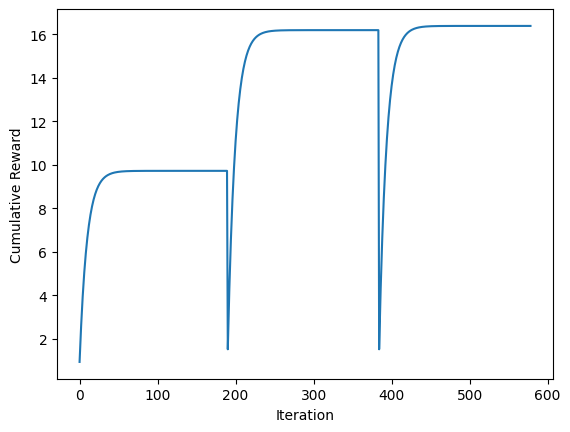


For State 0 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 1 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 2 | Optimal policy pi(s) = 1 | Expected Reward Gt = 0.75022

For State 3 | Optimal policy pi(s) = 1 | Expected Reward Gt = 0.75022

For State 4 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 5 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 6 | Optimal policy pi(s) = 1 | Expected Reward Gt = 0.75022

For State 7 | Optimal policy pi(s) = 1 | Expected Reward Gt = 0.75022

For State 8 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 9 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 10 | Optimal policy pi(s) = 1 | Expected Reward Gt = 0.76022

For State 11 | Optimal policy pi(s) = 1 | Expected Reward Gt = 0.76022

For State 12 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

For State 13 | Optimal policy pi(s) = 2 | Expected Reward Gt = 0.60833

F

In [13]:
if __name__ == '__main__':

    # Call Envirnment

    N = 3
    S, A, P, r_stock, gamma, c = mdp_environment(N)
    print("State Space:", S);print("")
    print("Action Space:", A);print("")
    print("Markov Chain Probabilities:");print(P);print("")
    print("Markov Chain Rewards:");print(r_stock);print("")
    print("Discount Factor:", gamma);print("")
    print("Transaction fee:", c);print("")


    # Call Agent

    V, pi, t = policy_iteration(S,A,P,r_stock,gamma,c,1e-10)

    if N < 4:
        for i in range(N*2**N):
            print("For State", i,"| Optimal policy pi(s) =",pi[i], "| Expected Reward Gt =", "{:.5f}".format(V[i]));print("")

    print("PI Algorithm Iterations : ", t)